# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [6]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [7]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [8]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [10]:

# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [13]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [14]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:16<00:00, 1432.53it/s]


In [17]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

<h2>1.4 Preprocessing of `project_title`</h2>

In [18]:
# Preprocessing of project title

from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values,position=0):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:03<00:00, 27441.45it/s]


<h1>2. Decision Tree </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [20]:
#joining resource data 
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [21]:
y=project_data['project_is_approved'].values
project_data.drop(['project_is_approved'],axis=1,inplace=True)

In [22]:
#Splitting the data into Training and Test data
    
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(project_data, y ,stratify=y, test_size=0.33,random_state=42) 

In [23]:
print("Train data : X_train Shape: ",X_train.shape, " y_train.shape : ",y_train.shape)
print("Test data : X_test Shape: ",X_test.shape, " Y_test.shape : ",y_test.shape)

Train data : X_train Shape:  (73196, 19)  y_train.shape :  (73196,)
Test data : X_test Shape:  (36052, 19)  Y_test.shape :  (36052,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

<h4> Numerical feature </h4>

In [24]:
#Creating feature names list as per the train matrix X
feature_list=[]

In [25]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#Standardization of   price   
from sklearn.preprocessing import StandardScaler
feature_list.extend(['Price'])
price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above mean and variance.
X_train_price_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
X_test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 296.81041231761293, Standard deviation : 359.7803649913931


In [26]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#Standardization of teacher_number_of_previously_posted_projects 

feature_list.extend(['Number of prev projects'])
no_projects_scalar=StandardScaler()
X_train_no_projects_standardized=no_projects_scalar.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.astype(float).reshape(-1,1))
print(f"Mean : {no_projects_scalar.mean_[0]}, Standard deviation : {np.sqrt(no_projects_scalar.var_[0])}")

X_test_no_projects_standardized = no_projects_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.08127493305645, Standard deviation : 27.573273132069115


C:\Users\Sampath Shetty\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [27]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#Standardization of   quantity   
feature_list.extend(['Quantity'])
quantity_scalar = StandardScaler()
X_train_quantity_standardized=quantity_scalar.fit_transform(X_train['quantity'].values.astype(float).reshape(-1,1))
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")

X_test_quantity_standardized = quantity_scalar.transform(X_test['quantity'].values.reshape(-1, 1))

Mean : 17.061355811792993, Standard deviation : 27.009940387973128


C:\Users\Sampath Shetty\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



<h4> Categorical data </h4>

In [28]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_categories_one_hot = vectorizer.fit_transform(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of train data matrix after one hot encoding ",X_train_categories_one_hot.shape)

X_test_categories_one_hot = vectorizer.transform(X_test['clean_categories'].values)
print("Shape of test matrix after one hot encoding ",X_test_categories_one_hot.shape)
feature_list.extend(vectorizer.get_feature_names())

['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
Shape of train data matrix after one hot encoding  (73196, 9)
Shape of test matrix after one hot encoding  (36052, 9)


In [29]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer()
X_train_sub_categories_one_hot = vectorizer.fit_transform(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of train data matrix after one hot encoding ",X_train_sub_categories_one_hot.shape)

X_test_sub_categories_one_hot = vectorizer.transform(X_test['clean_subcategories'].values)
print("Shape of test data matrix after one hot encoding ",X_test_sub_categories_one_hot.shape)
feature_list.extend(vectorizer.get_feature_names())

['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
Shape of train data matrix after one hot encoding  (73196, 30)
Shape of test data matrix after one hot encoding  (36052, 30)


In [30]:
#One hot encoding for School state
vectorizer = CountVectorizer()
X_train_state_one_hot=vectorizer.fit_transform(X_train['school_state'].values)
print(vectorizer.get_feature_names())
print("Shape of train data matrix after one hot encoding ",X_train_state_one_hot.shape)

X_test_state_one_hot = vectorizer.transform(X_test['school_state'].values)
print("Shape of test data matrix after one hot encoding ",X_test_state_one_hot.shape)
feature_list.extend(vectorizer.get_feature_names())

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of train data matrix after one hot encoding  (73196, 51)
Shape of test data matrix after one hot encoding  (36052, 51)


In [31]:
#Removing NaN and '.' from teacher prefix 
X_train[X_train['teacher_prefix'].isna()==True]
X_train['teacher_prefix'].fillna(method='pad',inplace=True)
X_train['teacher_prefix'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')



X_test[X_test['teacher_prefix'].isna()==True]
X_test['teacher_prefix'].fillna(method='pad',inplace=True)
X_test['teacher_prefix'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')

In [32]:
#One hot encoding for Teacher prefix
vectorizer = CountVectorizer()
X_train_teacher_prefix_one_hot=vectorizer.fit_transform(X_train['teacher_prefix'].values)
print(vectorizer.get_feature_names())
print("Shape of train data matrix after one hot encoding ",X_train_teacher_prefix_one_hot.shape)


X_test_teacher_prefix_one_hot = vectorizer.transform(X_test['teacher_prefix'].values)
print("Shape of test data matrix after one hot encoding ",X_test_teacher_prefix_one_hot.shape)
feature_list.extend(vectorizer.get_feature_names())

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of train data matrix after one hot encoding  (73196, 5)
Shape of test data matrix after one hot encoding  (36052, 5)


In [33]:
#One hot encoding for project_grade_category
vectorizer = CountVectorizer(vocabulary=X_train['project_grade_category'].unique().tolist(), lowercase=False, binary=True)
X_train_project_grade_category_one_hot=vectorizer.fit_transform(X_train['project_grade_category'].values)
print(vectorizer.get_feature_names())
print("Shape of train data matrix after one hot encoding ",X_train_project_grade_category_one_hot.shape)

X_test_project_grade_category_one_hot = vectorizer.transform(X_test['project_grade_category'].values)
print("Shape of test data matrix after one hot encoding ",X_test_project_grade_category_one_hot.shape)
feature_list.extend(vectorizer.get_feature_names())

['Grades PreK-2', 'Grades 9-12', 'Grades 3-5', 'Grades 6-8']
Shape of train data matrix after one hot encoding  (73196, 4)
Shape of test data matrix after one hot encoding  (36052, 4)


In [34]:
feature_list_tfidf=feature_list.copy()

<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [35]:
#Creating a list of preprocessed essay for train data, cv data and test data

X_train_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values,position=0):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    X_train_preprocessed_essays.append(sent.lower().strip())


    
    
X_test_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values,position=0):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    X_test_preprocessed_essays.append(sent.lower().strip())


100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:29<00:00, 1203.71it/s]


In [36]:
# Preprocessing of project title of train data

X_train_preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values,position=0):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_train_preprocessed_titles.append(sent.lower().strip())
    
    

# Preprocessing of project title of test data

X_test_preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values,position=0):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_test_preprocessed_titles.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:01<00:00, 21901.49it/s]


<h4> BOW </h4>

In [37]:
#BOW vectorization for essay text
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=100,max_features=500,ngram_range=(1, 2))
X_train_text_bow = vectorizer.fit_transform(X_train_preprocessed_essays)
print("Shape of train data matrix after BOW on essay text ",X_train_text_bow.shape)

X_test_text_bow = vectorizer.transform(X_test_preprocessed_essays)
print("Shape of test data matrix after BOW on essay text ",X_test_text_bow.shape)
feature_list.extend(vectorizer.get_feature_names())

Shape of train data matrix after BOW on essay text  (73196, 500)
Shape of test data matrix after BOW on essay text  (36052, 500)


In [38]:
#BOW vectorization for project title
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=100,max_features=500,ngram_range=(1, 2))
X_train_title_bow = vectorizer.fit_transform(X_train_preprocessed_titles)
print("Shape of train data matrix after BOW on project_title ",X_train_title_bow.shape)

X_test_title_bow = vectorizer.transform(X_test_preprocessed_titles)
print("Shape of test data matrix after BOW on project_title ",X_test_title_bow.shape)
feature_list.extend(vectorizer.get_feature_names())

Shape of train data matrix after BOW on project_title  (73196, 500)
Shape of test data matrix after BOW on project_title  (36052, 500)


<h4> TFIDF </h4>

In [39]:
#TFIDF vectorization for essay text
vectorizer = TfidfVectorizer(min_df=100,max_features=500,ngram_range=(1, 2))
X_train_text_tfidf = vectorizer.fit_transform(X_train_preprocessed_essays)
print("Shape of train data matrix after TFIDF on essay text ",X_train_text_tfidf.shape)

X_test_text_tfidf = vectorizer.transform(X_test_preprocessed_essays)
print("Shape of test data matrix after TFIDF on essay text ",X_test_text_tfidf.shape)
feature_list_tfidf.extend(vectorizer.get_feature_names())

Shape of train data matrix after TFIDF on essay text  (73196, 500)
Shape of test data matrix after TFIDF on essay text  (36052, 500)


In [40]:
# TFIDF vectorization for project_title 
vectorizer = TfidfVectorizer(min_df=100,max_features=500,ngram_range=(1, 2))
X_train_title_tfidf = vectorizer.fit_transform(X_train_preprocessed_titles)
print("Shape of train data matrix after TFIDF on project title ",X_train_title_tfidf.shape)

X_test_title_tfidf = vectorizer.transform(X_test_preprocessed_titles)
print("Shape of test data matrix after TFIDF on project title",X_test_title_tfidf.shape)
feature_list_tfidf.extend(vectorizer.get_feature_names())

Shape of train data matrix after TFIDF on project title  (73196, 500)
Shape of test data matrix after TFIDF on project title (36052, 500)


<h4> AVG W2V </h4>

In [41]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [42]:
# average Word2Vec
# compute average word2vec for each essay text.
X_train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_essays,position=0): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_vectors.append(vector)

print("Train data")
print(len(X_train_avg_w2v_vectors))
print(len(X_train_avg_w2v_vectors[0]))


X_test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_essays,position=0): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_vectors.append(vector)

print("Test data")
print(len(X_test_avg_w2v_vectors))
print(len(X_test_avg_w2v_vectors[0]))


100%|██████████████████████████████████████████████████████████████████████████| 73196/73196 [00:26<00:00, 2766.27it/s]


Train data
73196
300


100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:12<00:00, 2827.66it/s]


Test data
36052
300


In [43]:
#AVG W2V on project_title

X_train_avg_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_titles,position=0): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_vectors_title.append(vector)

print("Train data")
print(len(X_train_avg_w2v_vectors_title))
print(len(X_train_avg_w2v_vectors_title[0]))


X_test_avg_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_titles,position=0): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_vectors_title.append(vector)

print("Test data")
print(len(X_test_avg_w2v_vectors_title))
print(len(X_test_avg_w2v_vectors_title[0]))

100%|█████████████████████████████████████████████████████████████████████████| 73196/73196 [00:01<00:00, 56201.36it/s]


Train data
73196
300


100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 56617.20it/s]


Test data
36052
300


<h4> TFIDF W2V </h4>

In [44]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train_preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [45]:
# TFIDF Word2Vec

X_train_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_essays,position=0): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_vectors.append(vector)

print("Train data")
print(len(X_train_tfidf_w2v_vectors))
print(len(X_train_tfidf_w2v_vectors[0]))


X_test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_essays,position=0): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_vectors.append(vector)

print("Test data")
print(len(X_test_tfidf_w2v_vectors))
print(len(X_test_tfidf_w2v_vectors[0]))


100%|███████████████████████████████████████████████████████████████████████████| 73196/73196 [03:12<00:00, 381.21it/s]


Train data
73196
300


100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:29<00:00, 403.57it/s]


Test data
36052
300


In [46]:
#TFIDF W2V for title
tfidf_model_x = TfidfVectorizer()
tfidf_model_x.fit(X_train_preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_title = dict(zip(tfidf_model_x.get_feature_names(), list(tfidf_model_x.idf_)))
tfidf_words_title = set(tfidf_model_x.get_feature_names())


X_train_tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_titles,position=0): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_title):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_title[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_vectors_title.append(vector)

print("Train data")
print(len(X_train_tfidf_w2v_vectors_title))
print(len(X_train_tfidf_w2v_vectors_title[0]))

#For test data
X_test_tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_titles,position=0): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_title):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_title[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_vectors_title.append(vector)

print("Test data")
print(len(X_test_tfidf_w2v_vectors_title))
print(len(X_test_tfidf_w2v_vectors_title[0]))


100%|█████████████████████████████████████████████████████████████████████████| 73196/73196 [00:03<00:00, 23855.07it/s]


Train data
73196
300


100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:01<00:00, 24341.73it/s]


Test data
36052
300


In [47]:
# https://stackoverflow.com/questions/35585069/python-tabulating-confusion-matrix

def plot_cm(cm, target_names=[0,1] , title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',size=15)
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# Used from sample soultion
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### 2.4.1 Applying Decision Trees on BOW, SET 1

In [49]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_set1 = hstack((X_train_price_standardized,X_train_no_projects_standardized,X_train_quantity_standardized,\
                       X_train_categories_one_hot, X_train_sub_categories_one_hot,X_train_state_one_hot,\
                       X_train_teacher_prefix_one_hot,X_train_project_grade_category_one_hot,\
                       X_train_text_bow,X_train_title_bow))
print("Train data")
print("X shape: ",X_train_set1.shape," Y shape :", y_train.shape)

X_test_set1 = hstack((X_test_price_standardized,X_test_no_projects_standardized,X_test_quantity_standardized,\
                       X_test_categories_one_hot, X_test_sub_categories_one_hot,X_test_state_one_hot,\
                       X_test_teacher_prefix_one_hot,X_test_project_grade_category_one_hot,\
                       X_test_text_bow,X_test_title_bow))
print("Test data")
print("X shape: ",X_test_set1.shape," Y shape :", y_test.shape)


Train data
X shape:  (73196, 1102)  Y shape : (73196,)
Test data
X shape:  (36052, 1102)  Y shape : (36052,)


In [50]:
#Converting sparse matrix to dataframe
X_train_set1_df=pd.DataFrame(X_train_set1.todense(),columns=feature_list)
X_test_set1_df=pd.DataFrame(X_test_set1.todense(),columns=feature_list)

In [51]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier(class_weight='balanced',random_state=42)
parameters ={'max_depth': [1, 5, 10, 20, 30, 50],'min_samples_split':[5, 10, 100, 500]}


clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc')
clf.fit(X_train_set1_df, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(clf.best_estimator_)
print(clf.score(X_train_set1_df, y_train))



DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
0.7316097791101859


In [52]:
cvscore_df=pd.DataFrame(cv_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])
trainscore_df=pd.DataFrame(train_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])

In [57]:
cvscore_df

5         10        100       500
1   0.567228  0.567228  0.567228  0.567228
5   0.663603  0.663571  0.663688  0.664061
10  0.673972  0.672337  0.675675  0.683905
20  0.627558  0.627060  0.650719  0.674061
30  0.599997  0.602455  0.636093  0.665654
50  0.578305  0.581590  0.619506  0.659269

In [58]:
trainscore_df

5         10        100       500
1   0.569043  0.569043  0.569043  0.569043
5   0.676453  0.676441  0.676263  0.675736
10  0.767630  0.765447  0.751504  0.731788
20  0.916089  0.904773  0.840122  0.775800
30  0.962327  0.951275  0.874235  0.790446
50  0.988869  0.981470  0.900768  0.799026

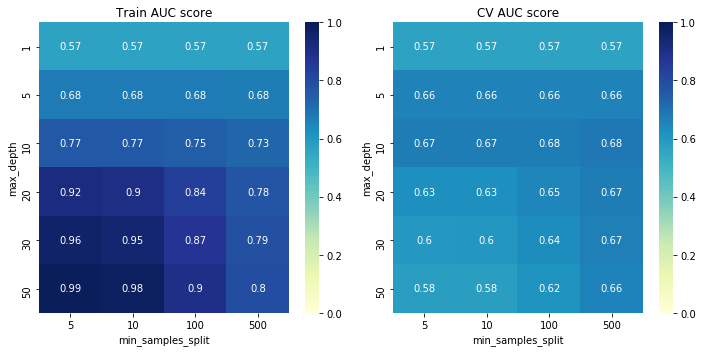

In [64]:
# Plotting heat map of AUC scores
plt.figure(1,figsize=(10,5))
plt.subplot(121)    
sns.heatmap(trainscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('Train AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.subplot(122)    
sns.heatmap(cvscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('CV AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.tight_layout()

From the train AUC score, we can see that with large max_depth parameter the model is being overfitted. Value of max_depth 10 and min_samples_split as 500 looks optimal.

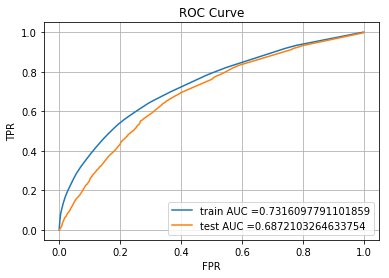

In [65]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

dtc = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, min_samples_split=500,random_state=42)

dtc.fit(X_train_set1_df, y_train)

y_train_pred = dtc.predict_proba(X_train_set1_df) [:,1]   
y_test_pred = dtc.predict_proba(X_test_set1_df) [:,1]   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.4532592631221173 for threshold 0.481
None


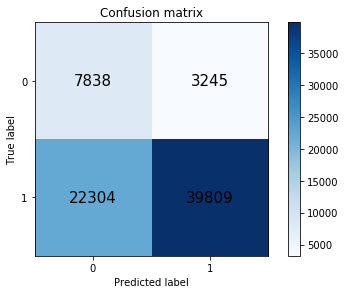

In [66]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(plot_cm(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.42221408112214953 for threshold 0.443
None


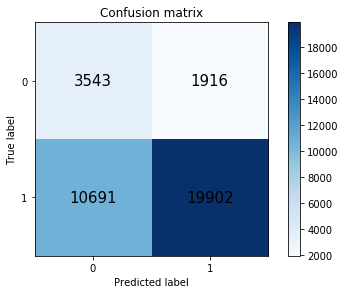

In [67]:
print("Test confusion matrix")
pred = predict(y_test_pred, te_thresholds, test_fpr, test_tpr)
print(plot_cm(confusion_matrix(y_test, pred)))

<h4> WordCloud - Project essay for false positive data points</h4>

In [68]:
#Creating a list of essays which belong to FP
fp_idx=[]
for _ in range(len(pred)):
    if(pred[_]==1 and y_test[_]==0):
        fp_idx.append(_)
fp_essay=[X_test_preprocessed_essays[_] for _ in fp_idx]

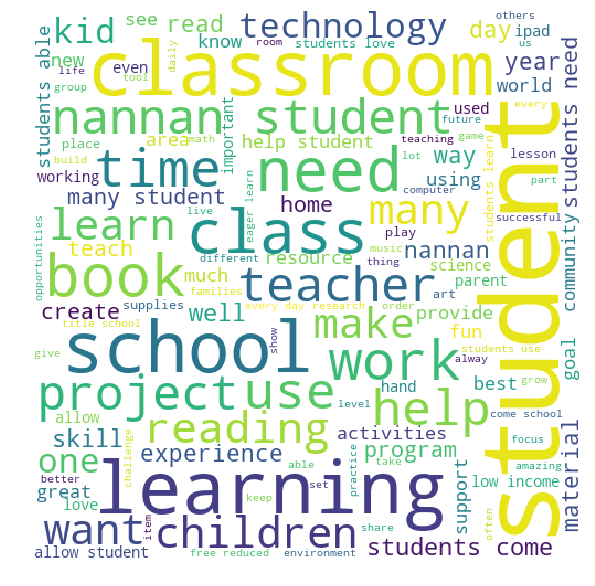

In [69]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
# Python program to generate WordCloud 
  
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import pandas as pd 
  
words = ' '  
# iterate through the csv file 
for val in fp_essay: 
          
    for _ in val.split(): 
        words = words + _ + ' '
  
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 


<h4> Box plot with the price of these false positive data points</h4>

In [70]:
positive_idx=[]
negative_idx=[]
for i in range(len(y_test)):
    if y_test[i]==1:
        positive_idx.append(i)
    else:
        negative_idx.append(i)

In [71]:
fp_price=list(X_test.reset_index().price.iloc[fp_idx])
positive_price=list(X_test.reset_index().price.iloc[positive_idx])
negative_price=list(X_test.reset_index().price.iloc[negative_idx])

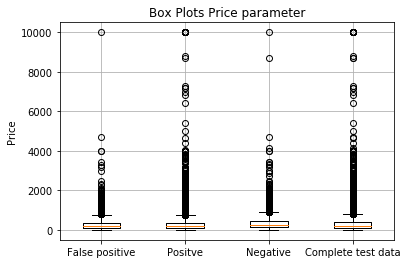

In [72]:
# Plotting box plot
plt.boxplot([fp_price, positive_price, negative_price, X_test['price']])
plt.title('Box Plots Price parameter')
plt.xticks([1,2 ,3 ,4 ],('False positive','Positve','Negative','Complete test data'))
plt.ylabel('Price')
plt.grid()
plt.show()

<h4> Pdf with the teacher_number_of_previously_posted_projects of these false positive data points </h4>

In [73]:
fp_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[fp_idx])
postive_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[positive_idx])
negative_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[negative_idx])

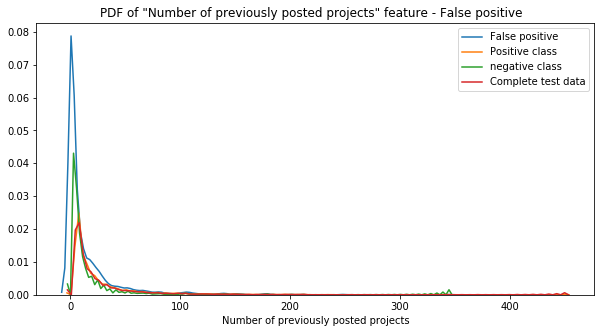

In [74]:
# Plotting pdf
plt.figure(figsize=(10,5))
sns.distplot(fp_n_projects, hist=False, label="False positive")
sns.distplot(postive_n_projects, hist=False, label="Positive class")
sns.distplot(negative_n_projects, hist=False, label="negative class")
sns.distplot(X_test.teacher_number_of_previously_posted_projects, hist=False, label="Complete test data")
plt.title('PDF of "Number of previously posted projects" feature - False positive  ')
plt.xlabel('Number of previously posted projects')
plt.legend()
plt.show()

#### 2.4.1.1 Graphviz visualization of Decision Tree on BOW, SET 1

In [109]:
# http://dataaspirant.com/2017/04/21/visualize-decision-tree-python-graphviz/
from sklearn import tree
with open("Decision_tree_graphviz.txt", "w") as f:
    f = tree.export_graphviz(dtc, out_file=f,feature_names=X_train_set1_df.columns,max_depth=2)


<img src='BOW_graphviz.PNG'>

### 2.4.2 Applying Decision Trees on TFIDF, SET 2

In [75]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_set2 = hstack((X_train_price_standardized,X_train_no_projects_standardized,X_train_quantity_standardized,\
                       X_train_categories_one_hot, X_train_sub_categories_one_hot,X_train_state_one_hot,\
                       X_train_teacher_prefix_one_hot,X_train_project_grade_category_one_hot,\
                       X_train_text_tfidf,X_train_title_tfidf))
print("Train data")
print("X shape: ",X_train_set2.shape," Y shape :", y_train.shape)

X_test_set2 = hstack((X_test_price_standardized,X_test_no_projects_standardized,X_test_quantity_standardized,\
                       X_test_categories_one_hot, X_test_sub_categories_one_hot,X_test_state_one_hot,\
                       X_test_teacher_prefix_one_hot,X_test_project_grade_category_one_hot,\
                       X_test_text_tfidf,X_test_title_tfidf))
print("Test data")
print("X shape: ",X_test_set2.shape," Y shape :", y_test.shape)


Train data
X shape:  (73196, 1102)  Y shape : (73196,)
Test data
X shape:  (36052, 1102)  Y shape : (36052,)


In [76]:
#Converting sparse matrix to dataframe
X_train_set2_df=pd.DataFrame(X_train_set2.todense(),columns=feature_list)
X_test_set2_df=pd.DataFrame(X_test_set2.todense(),columns=feature_list)

In [77]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier(class_weight='balanced',random_state=42)
parameters ={'max_depth': [1, 5, 10, 20, 30, 50],'min_samples_split':[5, 10, 100, 500]}


clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc')
clf.fit(X_train_set2_df, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(clf.best_estimator_)
print(clf.score(X_train_set2_df, y_train))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
0.7344326467392799


In [78]:
cvscore_df=pd.DataFrame(cv_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])
trainscore_df=pd.DataFrame(train_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])

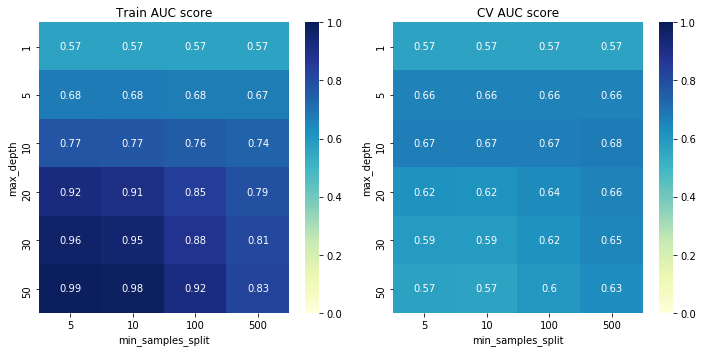

In [81]:
#plotting heatmap
plt.figure(1,figsize=(10,5))
plt.subplot(121)    
sns.heatmap(trainscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('Train AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.subplot(122)    
sns.heatmap(cvscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('CV AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.tight_layout()

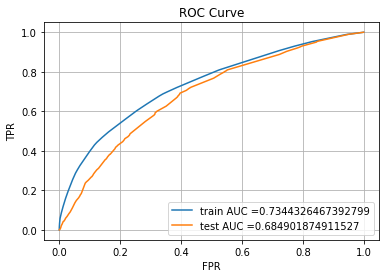

In [82]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

dtc = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, min_samples_split=500,random_state=42)

dtc.fit(X_train_set2_df, y_train)

y_train_pred = dtc.predict_proba(X_train_set2_df) [:,1]   
y_test_pred = dtc.predict_proba(X_test_set2_df) [:,1]   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.4551986967999528 for threshold 0.498
None


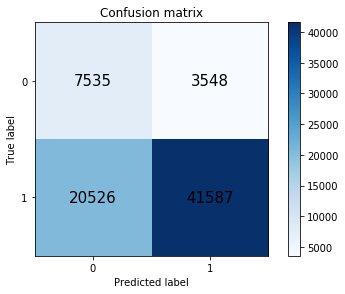

In [83]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(plot_cm(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.41749996663317246 for threshold 0.416
None


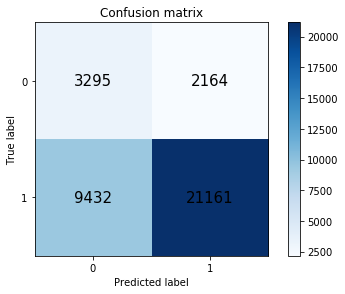

In [84]:
print("Test confusion matrix")
print(plot_cm(confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))))

<h4> WordCloud - Project essay for false positive data points</h4>

In [85]:
#Creating a list of essays which belong to FP
fp_idx=[]
for _ in range(len(pred)):
    if(pred[_]==1 and y_test[_]==0):
        fp_idx.append(_)
fp_essay=[X_test_preprocessed_essays[_] for _ in fp_idx]

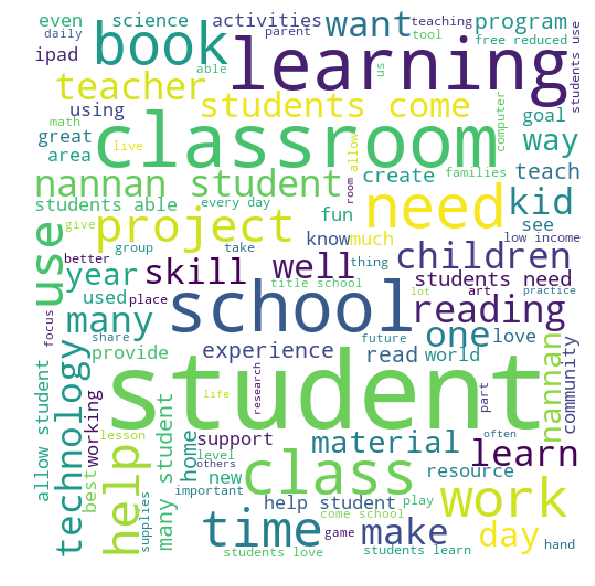

In [86]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
# Python program to generate WordCloud 
  
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import pandas as pd 
  
words = ' '  
# iterate through the csv file 
for val in fp_essay: 
          
    for _ in val.split(): 
        words = words + _ + ' '
  
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 


<h4> Box plot with the price of these false positive data points</h4>

In [87]:
positive_idx=[]
negative_idx=[]
for i in range(len(y_test)):
    if y_test[i]==1:
        positive_idx.append(i)
    else:
        negative_idx.append(i)

In [88]:
fp_price=list(X_test.reset_index().price.iloc[fp_idx])
positive_price=list(X_test.reset_index().price.iloc[positive_idx])
negative_price=list(X_test.reset_index().price.iloc[negative_idx])

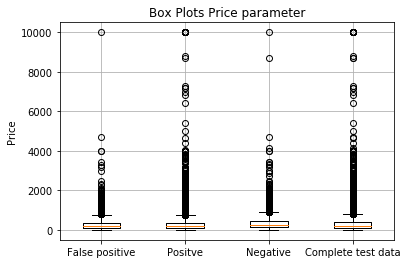

In [89]:
#plotting boxplot
plt.boxplot([fp_price, positive_price, negative_price, X_test['price']])
plt.title('Box Plots Price parameter')
plt.xticks([1,2 ,3 ,4 ],('False positive','Positve','Negative','Complete test data'))
plt.ylabel('Price')
plt.grid()
plt.show()

<h4> Pdf with the teacher_number_of_previously_posted_projects of these false positive data points </h4>

In [91]:
fp_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[fp_idx])
postive_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[positive_idx])
negative_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[negative_idx])

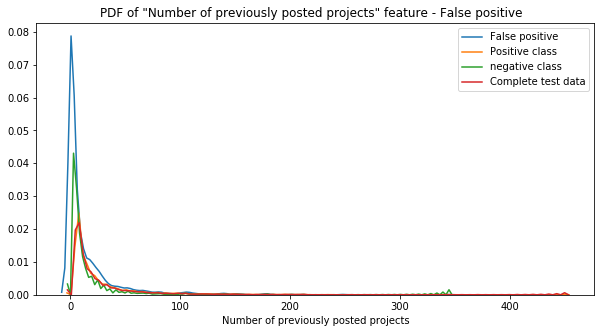

In [92]:
#plotting pdf
plt.figure(figsize=(10,5))
sns.distplot(fp_n_projects, hist=False, label="False positive")
sns.distplot(postive_n_projects, hist=False, label="Positive class")
sns.distplot(negative_n_projects, hist=False, label="negative class")
sns.distplot(X_test.teacher_number_of_previously_posted_projects, hist=False, label="Complete test data")
plt.title('PDF of "Number of previously posted projects" feature - False positive  ')
plt.xlabel('Number of previously posted projects')
plt.legend()
plt.show()

#### 2.4.2.1 Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [125]:
# http://dataaspirant.com/2017/04/21/visualize-decision-tree-python-graphviz/
from sklearn import tree
with open("Decision_tree_graphviz.txt", "w") as f:
    f = tree.export_graphviz(dtc, out_file=f,feature_names=X_train_set1_df.columns,max_depth=2)

<img src='Tfidf-graphviz.png'>

In [93]:
feature_imp=dtc.feature_importances_

### 2.4.3 Applying Decision Trees on AVG W2V, SET 3

In [94]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_set3 = hstack((X_train_price_standardized,X_train_no_projects_standardized,X_train_quantity_standardized,\
                       X_train_categories_one_hot, X_train_sub_categories_one_hot,X_train_state_one_hot,\
                       X_train_teacher_prefix_one_hot,X_train_project_grade_category_one_hot,\
                       X_train_avg_w2v_vectors,X_train_avg_w2v_vectors_title))
print("Train data")
print("X shape: ",X_train_set3.shape," Y shape :", y_train.shape)

X_test_set3 = hstack((X_test_price_standardized,X_test_no_projects_standardized,X_test_quantity_standardized,\
                       X_test_categories_one_hot, X_test_sub_categories_one_hot,X_test_state_one_hot,\
                       X_test_teacher_prefix_one_hot,X_test_project_grade_category_one_hot,\
                       X_test_avg_w2v_vectors,X_test_avg_w2v_vectors_title))
print("Test data")
print("X shape: ",X_test_set3.shape," Y shape :", y_test.shape)


Train data
X shape:  (73196, 702)  Y shape : (73196,)
Test data
X shape:  (36052, 702)  Y shape : (36052,)


In [95]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier(class_weight='balanced',random_state=42)
parameters ={'max_depth': [1, 5, 10, 20, 30, 50],'min_samples_split':[5, 10, 100, 500]}


clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc')
clf.fit(X_train_set3, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(clf.best_estimator_)
print(clf.score(X_train_set3, y_train))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
0.6826072821127315


In [96]:
cvscore_df=pd.DataFrame(cv_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])
trainscore_df=pd.DataFrame(train_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])

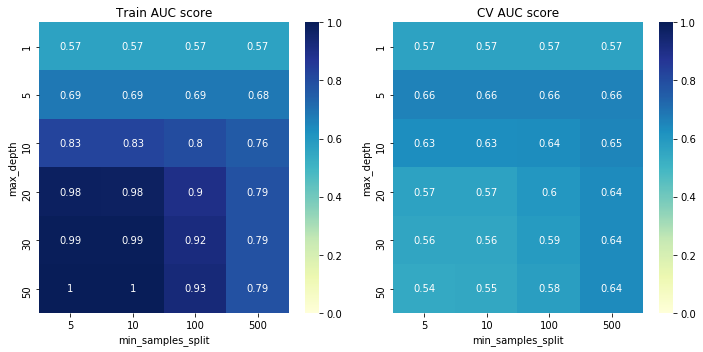

In [97]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)    
sns.heatmap(trainscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('Train AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.subplot(122)    
sns.heatmap(cvscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('CV AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.tight_layout()

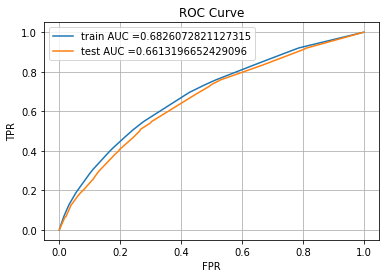

In [98]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

dtc = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, min_samples_split=500,random_state=42)

dtc.fit(X_train_set3, y_train)

y_train_pred = dtc.predict_proba(X_train_set3) [:,1]   
y_test_pred = dtc.predict_proba(X_test_set3) [:,1]   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.3985031071666716 for threshold 0.495
None


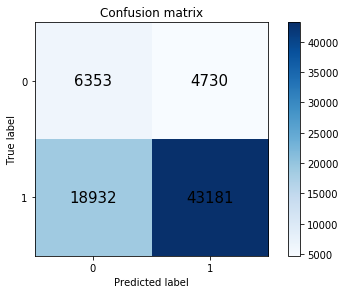

In [99]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(plot_cm(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3821092382090119 for threshold 0.519
None


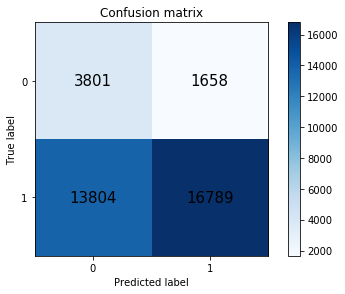

In [100]:
print("Test confusion matrix")
print(plot_cm(confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))))

<h4> WordCloud - Project essay for false positive data points</h4>

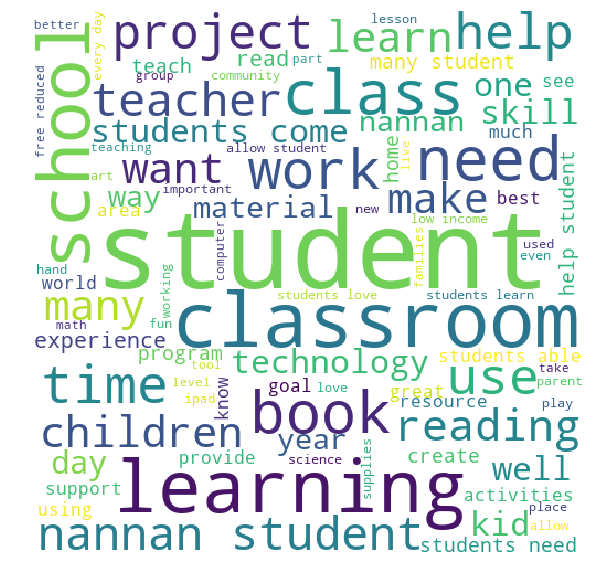

In [101]:
#Creating a list of essays which belong to FP
fp_idx=[]
for _ in range(len(pred)):
    if(pred[_]==1 and y_test[_]==0):
        fp_idx.append(_)
fp_essay=[X_test_preprocessed_essays[_] for _ in fp_idx]

#https://www.geeksforgeeks.org/generating-word-cloud-python/
# Python program to generate WordCloud 
  
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import pandas as pd 
  
words = ' '  
# iterate through the csv file 
for val in fp_essay: 
          
    for _ in val.split(): 
        words = words + _ + ' '
  
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

<h4>Box plot with the price of these false positive data points</h4>

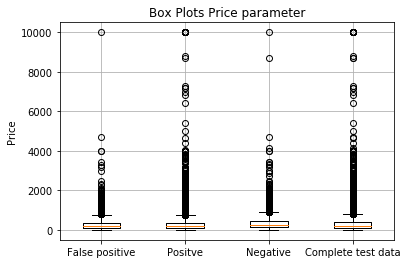

In [102]:
positive_idx=[]
negative_idx=[]
for i in range(len(y_test)):
    if y_test[i]==1:
        positive_idx.append(i)
    else:
        negative_idx.append(i)
        
        
fp_price=list(X_test.reset_index().price.iloc[fp_idx])
positive_price=list(X_test.reset_index().price.iloc[positive_idx])
negative_price=list(X_test.reset_index().price.iloc[negative_idx])


#plotting Box plot
plt.boxplot([fp_price, positive_price, negative_price, X_test['price']])
plt.title('Box Plots Price parameter')
plt.xticks([1,2 ,3 ,4 ],('False positive','Positve','Negative','Complete test data'))
plt.ylabel('Price')
plt.grid()
plt.show()

<h4>Pdf with the teacher_number_of_previously_posted_projects of these false positive data points</h4>

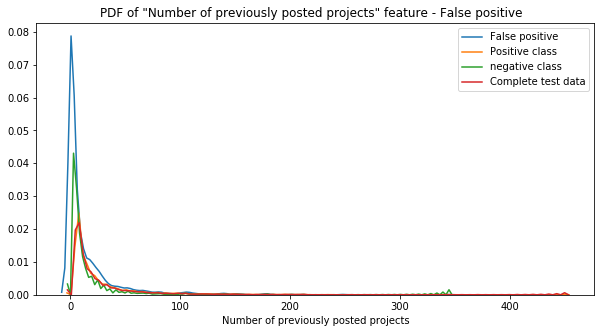

In [103]:
fp_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[fp_idx])
postive_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[positive_idx])
negative_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[negative_idx])

#plotting pdf
plt.figure(figsize=(10,5))
sns.distplot(fp_n_projects, hist=False, label="False positive")
sns.distplot(postive_n_projects, hist=False, label="Positive class")
sns.distplot(negative_n_projects, hist=False, label="negative class")
sns.distplot(X_test.teacher_number_of_previously_posted_projects, hist=False, label="Complete test data")
plt.title('PDF of "Number of previously posted projects" feature - False positive  ')
plt.xlabel('Number of previously posted projects')
plt.legend()
plt.show()

### 2.4.4 Applying Decision Trees on TFIDF W2V, SET 4

In [104]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_set4 = hstack((X_train_price_standardized,X_train_no_projects_standardized,X_train_quantity_standardized,\
                       X_train_categories_one_hot, X_train_sub_categories_one_hot,X_train_state_one_hot,\
                       X_train_teacher_prefix_one_hot,X_train_project_grade_category_one_hot,\
                       X_train_tfidf_w2v_vectors,X_train_tfidf_w2v_vectors_title))
print("Train data")
print("X shape: ",X_train_set4.shape," Y shape :", y_train.shape)

X_test_set4 = hstack((X_test_price_standardized,X_test_no_projects_standardized,X_test_quantity_standardized,\
                       X_test_categories_one_hot, X_test_sub_categories_one_hot,X_test_state_one_hot,\
                       X_test_teacher_prefix_one_hot,X_test_project_grade_category_one_hot,\
                       X_test_tfidf_w2v_vectors,X_test_tfidf_w2v_vectors))
print("Test data")
print("X shape: ",X_test_set4.shape," Y shape :", y_test.shape)


Train data
X shape:  (73196, 702)  Y shape : (73196,)
Test data
X shape:  (36052, 702)  Y shape : (36052,)


In [105]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier(class_weight='balanced',random_state=42)
parameters ={'max_depth': [1, 5, 10, 20, 30, 50],'min_samples_split':[5, 10, 100, 500]}


clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc')
clf.fit(X_train_set4, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(clf.best_estimator_)
print(clf.score(X_train_set4, y_train))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
0.6811750300475359


In [106]:
cvscore_df=pd.DataFrame(cv_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])
trainscore_df=pd.DataFrame(train_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])

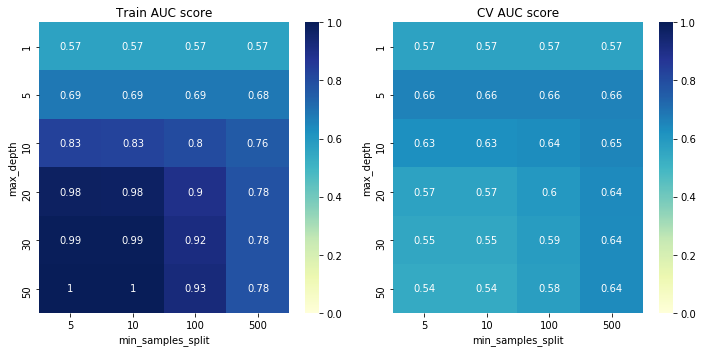

In [107]:
#plotting heatmap
plt.figure(1,figsize=(10,5))
plt.subplot(121)    
sns.heatmap(trainscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('Train AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.subplot(122)    
sns.heatmap(cvscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('CV AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.tight_layout()

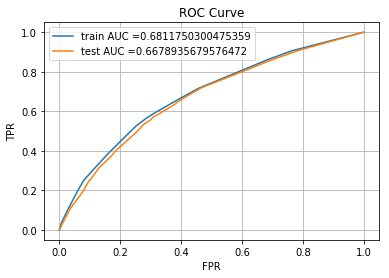

In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

dtc = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, min_samples_split=500,random_state=42)

dtc.fit(X_train_set4, y_train)

y_train_pred = dtc.predict_proba(X_train_set4) [:,1]   
y_test_pred = dtc.predict_proba(X_test_set4) [:,1]   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.4064663725769755 for threshold 0.486
None


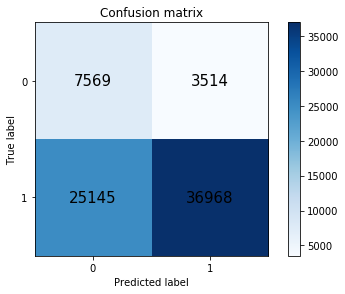

In [109]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(plot_cm(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.39597487502139644 for threshold 0.465
None


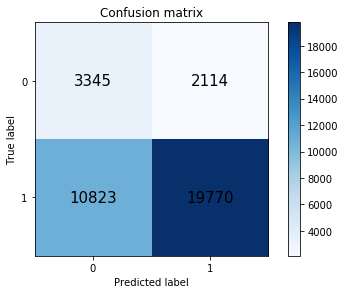

In [110]:
print("Test confusion matrix")
print(plot_cm(confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))))

<h4> WordCloud - Project essay for false positive data points</h4>

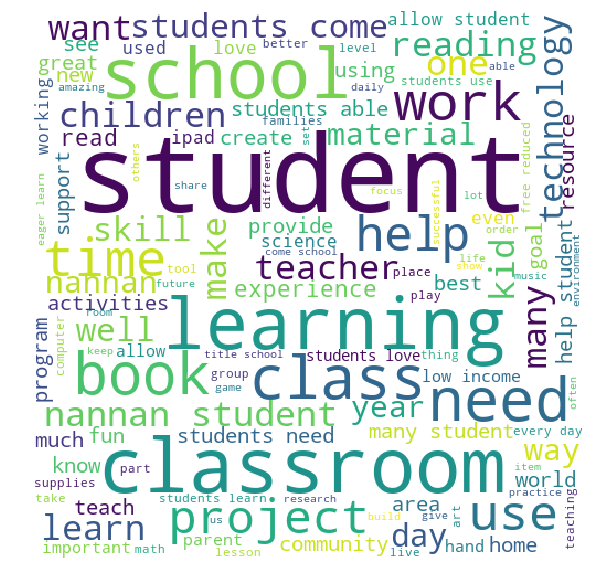

In [111]:
#Creating a list of essays which belong to FP
fp_idx=[]
for _ in range(len(pred)):
    if(pred[_]==1 and y_test[_]==0):
        fp_idx.append(_)
fp_essay=[X_test_preprocessed_essays[_] for _ in fp_idx]

#https://www.geeksforgeeks.org/generating-word-cloud-python/
# Python program to generate WordCloud 
  
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import pandas as pd 
  
words = ' '  
# iterate through the csv file 
for val in fp_essay: 
          
    for _ in val.split(): 
        words = words + _ + ' '
  
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

<h4> Box plot with the price of these false positive data points </h4>

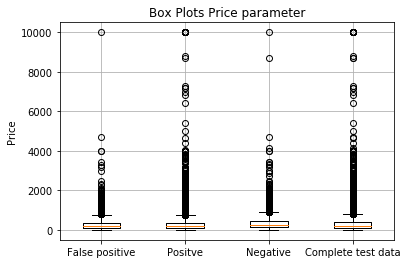

In [112]:
positive_idx=[]
negative_idx=[]
for i in range(len(y_test)):
    if y_test[i]==1:
        positive_idx.append(i)
    else:
        negative_idx.append(i)
        
        
fp_price=list(X_test.reset_index().price.iloc[fp_idx])
positive_price=list(X_test.reset_index().price.iloc[positive_idx])
negative_price=list(X_test.reset_index().price.iloc[negative_idx])


#plotting Box plot
plt.boxplot([fp_price, positive_price, negative_price, X_test['price']])
plt.title('Box Plots Price parameter')
plt.xticks([1,2 ,3 ,4 ],('False positive','Positve','Negative','Complete test data'))
plt.ylabel('Price')
plt.grid()
plt.show()

<h4> Pdf with the teacher_number_of_previously_posted_projects of these false positive data points </h4>

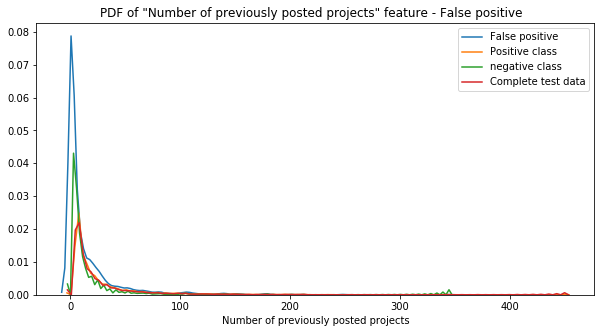

In [113]:
fp_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[fp_idx])
postive_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[positive_idx])
negative_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[negative_idx])

#plotting pdf
plt.figure(figsize=(10,5))
sns.distplot(fp_n_projects, hist=False, label="False positive")
sns.distplot(postive_n_projects, hist=False, label="Positive class")
sns.distplot(negative_n_projects, hist=False, label="negative class")
sns.distplot(X_test.teacher_number_of_previously_posted_projects, hist=False, label="Complete test data")
plt.title('PDF of "Number of previously posted projects" feature - False positive  ')
plt.xlabel('Number of previously posted projects')
plt.legend()
plt.show()

<h2>2.5 Getting top 5k features using `feature_importances_`</h2>

In [202]:
#selected 500 features

In [114]:
# Selecting top 500 feature 
from operator import itemgetter 
idx=feature_imp.argsort()[-500:][::-1]
feature_500=list(itemgetter(*idx)(feature_list_tfidf))

In [115]:
X_train_set5=X_train_set2_df.iloc[:,idx]
X_test_set5=X_test_set2_df.iloc[:,idx]

In [116]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier(class_weight='balanced',random_state=42)
parameters ={'max_depth': [1, 5, 10, 20, 30, 50],'min_samples_split':[5, 10, 100, 500]}


clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc')
clf.fit(X_train_set5, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(clf.best_estimator_)
print(clf.score(X_train_set5, y_train))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
0.7344326467392799


In [117]:
cvscore_df=pd.DataFrame(cv_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])
trainscore_df=pd.DataFrame(train_auc.reshape(6,4),index=parameters['max_depth'],columns=parameters['min_samples_split'])

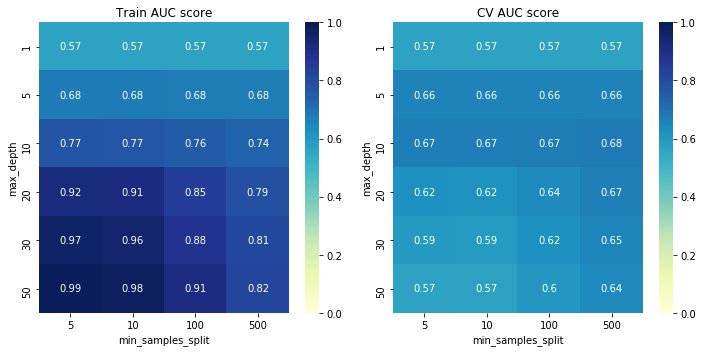

In [119]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)    
sns.heatmap(trainscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('Train AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.subplot(122)    
sns.heatmap(cvscore_df, cmap="YlGnBu",vmin=0,vmax=1,annot=True)
plt.title('CV AUC score')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.tight_layout()

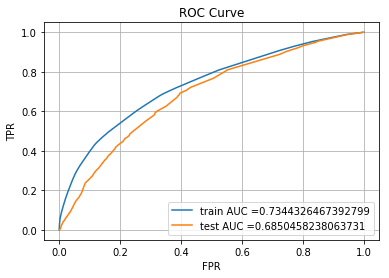

In [120]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

dtc = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, min_samples_split=500,random_state=42)

dtc.fit(X_train_set5, y_train)

y_train_pred = dtc.predict_proba(X_train_set5) [:,1]   
y_test_pred = dtc.predict_proba(X_test_set5) [:,1]   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.4551986967999528 for threshold 0.498
None


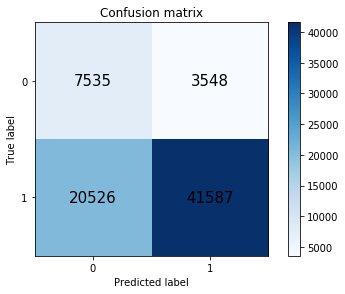

In [121]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(plot_cm(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.41760693807746124 for threshold 0.416
None


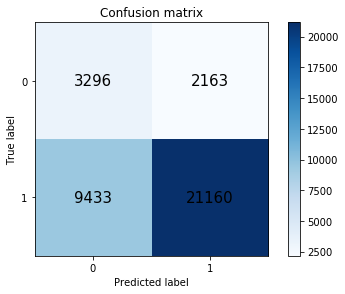

In [122]:
print("Test confusion matrix")
print(plot_cm(confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))))

<h4>WordCloud - Project essay for false positive data points</h4>

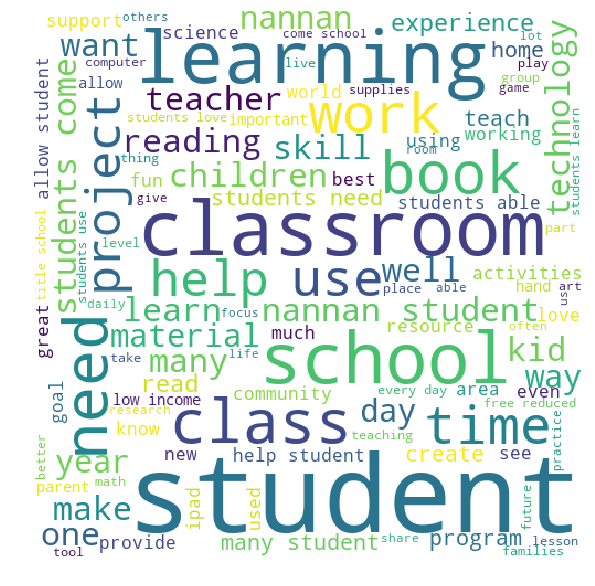

In [123]:
#Creating a list of essays which belong to FP
fp_idx=[]
for _ in range(len(pred)):
    if(pred[_]==1 and y_test[_]==0):
        fp_idx.append(_)
fp_essay=[X_test_preprocessed_essays[_] for _ in fp_idx]


#https://www.geeksforgeeks.org/generating-word-cloud-python/
# Python program to generate WordCloud 
  
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import pandas as pd 
  
words = ' '  
# iterate through the csv file 
for val in fp_essay: 
          
    for _ in val.split(): 
        words = words + _ + ' '
  
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

<h4>Box plot with the price of these false positive data points</h4>

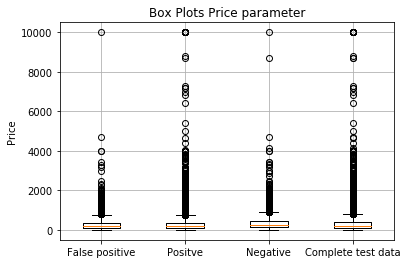

In [124]:
positive_idx=[]
negative_idx=[]
for i in range(len(y_test)):
    if y_test[i]==1:
        positive_idx.append(i)
    else:
        negative_idx.append(i)


fp_price=list(X_test.reset_index().price.iloc[fp_idx])
positive_price=list(X_test.reset_index().price.iloc[positive_idx])
negative_price=list(X_test.reset_index().price.iloc[negative_idx])



plt.boxplot([fp_price, positive_price, negative_price, X_test['price']])
plt.title('Box Plots Price parameter')
plt.xticks([1,2 ,3 ,4 ],('False positive','Positve','Negative','Complete test data'))
plt.ylabel('Price')
plt.grid()
plt.show()

<h4>Pdf with the teacher_number_of_previously_posted_projects of these false positive data points </h4>

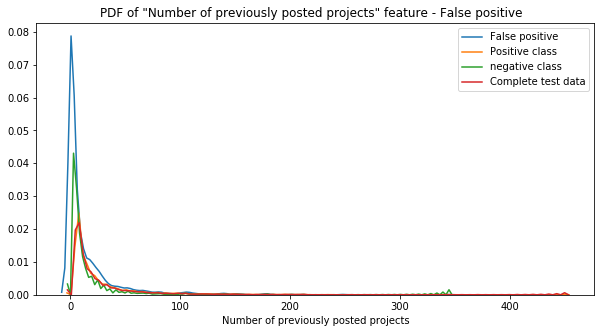

In [125]:
fp_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[fp_idx])
postive_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[positive_idx])
negative_n_projects=list(X_test.reset_index().teacher_number_of_previously_posted_projects.iloc[negative_idx])


plt.figure(figsize=(10,5))
sns.distplot(fp_n_projects, hist=False, label="False positive")
sns.distplot(postive_n_projects, hist=False, label="Positive class")
sns.distplot(negative_n_projects, hist=False, label="negative class")
sns.distplot(X_test.teacher_number_of_previously_posted_projects, hist=False, label="Complete test data")
plt.title('PDF of "Number of previously posted projects" feature - False positive  ')
plt.xlabel('Number of previously posted projects')
plt.legend()
plt.show()

<h3> Logistic Regression </h4>

In [126]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from math import *


lr = LogisticRegression(class_weight='balanced')
parameters ={'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4]}

log_parameter=[log(_) for _ in parameters['C']]



clf = GridSearchCV(lr, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_set5, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(clf.best_estimator_)
print(clf.score(X_train_set5, y_train))

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.7170302655520924


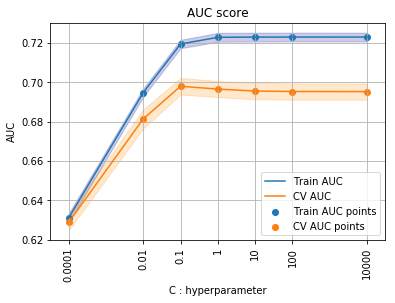

In [127]:
plt.plot(log_parameter, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_parameter,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_parameter, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_parameter,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_parameter, train_auc, label='Train AUC points')
plt.scatter(log_parameter, cv_auc, label='CV AUC points')


plt.legend()
plt.xticks(log_parameter,parameters['C'],rotation='vertical')
plt.xlabel("C : hyperparameter")
plt.ylabel("AUC")
plt.title("AUC score")
plt.grid()
plt.show()

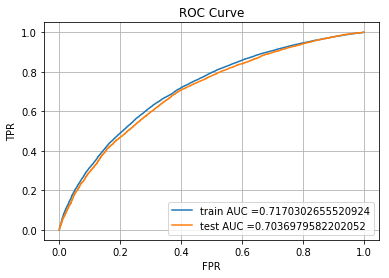

In [128]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


lr = LogisticRegression(C=0.1,class_weight='balanced')
lr.fit(X_train_set5, y_train)

y_train_pred = lr.predict_proba(X_train_set5) [:,1]   
y_test_pred = lr.predict_proba(X_test_set5) [:,1]   

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.43868446558326374 for threshold 0.492
None


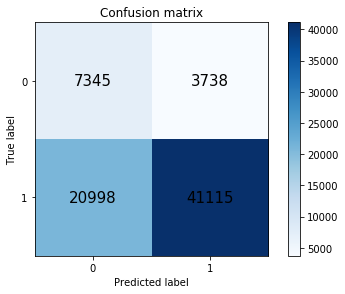

In [129]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(plot_cm(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.42789238764916143 for threshold 0.484
None


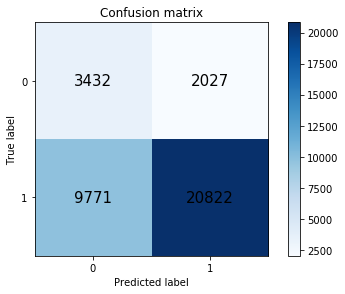

In [130]:
print("Test confusion matrix")
print(plot_cm(confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))))

<h1>3. Conclusion</h1>

In [235]:
from prettytable import PrettyTable
# http://zetcode.com/python/prettytable/
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter max_depth","min_samples_split=500", "AUC"]
x.add_row(['SET1 - BOW','DecisionTreeClassifier','10', '500', '0.687'])
x.add_row(['SET2 - TFIDF','DecisionTreeClassifier','10', '500', '0.684'])
x.add_row(['SET3 - AVG W2V','DecisionTreeClassifier','5' ,'500', '0.661'])
x.add_row(['SET4 - TFIDF W2V','DecisionTreeClassifier','5', '500', '0.661'])
x.add_row(['500 features from set2','DecisionTreeClassifier','10' ,'500' ,'0.685' ])
x.add_row(['500 features from set2','Logistic Regression','C=0.1' ,' ' ,'0.70' ])

print(x)

+------------------------+------------------------+---------------------------+-----------------------+-------+
|       Vectorizer       |         Model          | Hyper parameter max_depth | min_samples_split=500 |  AUC  |
+------------------------+------------------------+---------------------------+-----------------------+-------+
|       SET1 - BOW       | DecisionTreeClassifier |             10            |          500          | 0.687 |
|      SET2 - TFIDF      | DecisionTreeClassifier |             10            |          500          | 0.684 |
|     SET3 - AVG W2V     | DecisionTreeClassifier |             5             |          500          | 0.661 |
|    SET4 - TFIDF W2V    | DecisionTreeClassifier |             5             |          500          | 0.661 |
| 500 features from set2 | DecisionTreeClassifier |             10            |          500          | 0.685 |
| 500 features from set2 |  Logistic Regression   |           C=0.1           |                       | 

From the box plot and pdf, we can see that the values for both the class are almost similar.

#### Overview

- SET1:
    - For set1, we have merged categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW with bi-grams with min_df=100 and max_features=500).
    - Performed hyperparameter tuning for  different max_depth and min_samples_split values i.e 'max_depth': [1, 5, 10, 20, 30, 50], 'min_samples_split':[5, 10, 100, 500]. For set 1 we found that max_depth value of 10 and min_samples_split as 500 provided the maximum AUC score.
    - Built final Decision Tree model using max_depth value as 10, min_samples_split as 500 and got an AUC value of 0.687 for test data. 
    
- SET2:
    - For set2, we have merged categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF with bi-grams with min_df=100 and max_features=500)
    - Performed hyperparameter tuning for  different max_depth and min_samples_split values i.e 'max_depth': [1, 5, 10, 20, 30, 50], 'min_samples_split':[5, 10, 100, 500]. For set 2 we found that max_depth value of 10 and min_samples_split as 500 provided the maximum AUC score.
    - Built final Decision Tree model using max_depth value as 10, min_samples_split as 500 and got an AUC value of 0.684 for test data.

- SET3
    - For set3 we have merged categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)
    - Performed hyperparameter tuning for  different max_depth and min_samples_split values i.e 'max_depth': [1, 5, 10, 20, 30, 50], 'min_samples_split':[5, 10, 100, 500]. For set 3 we found that max_depth value of 5 and min_samples_split as 500 provided the maximum AUC score.
    - Built final Decision Tree model using max_depth value as 5, min_samples_split as 500 and got an AUC value of 0.661 for test data.

- SET4
    - For set4 we have merged categorical, numerical features + project_titleTFIDF W2V)+ preprocessed_eassay (TFIDF W2V)
    - Performed hyperparameter tuning for  different max_depth and min_samples_split values i.e 'max_depth': [1, 5, 10, 20, 30, 50], 'min_samples_split':[5, 10, 100, 500]. For set 4 we found that max_depth value of 5 and min_samples_split as 500 provided the maximum AUC score.
    - Built final Decision Tree model using max_depth value as 5, min_samples_split as 500 and got an AUC value of 0.667 for test data.

- SET5
    - For set5 we have selected top 500 features based on set 2 using feature importance.
    - Decision tree
        - Performed hyperparameter tuning for  different max_depth and min_samples_split values i.e 'max_depth': [1, 5, 10, 20, 30, 50], 'min_samples_split':[5, 10, 100, 500]. For set 5 we found that max_depth value of 10 and min_samples_split as 500 provided the maximum AUC score.
        - Built final Decision Tree model using max_depth value as 10, min_samples_split as 500 and got an AUC value of 0.685 for test data.
    - Logistic regression
        - Performed hyperparameter tuning for  different C values i.e C values i.e from $10^{-4}$ to $10^{4}$. For set 5 we found that C value of 0.1 provided the maximum AUC score.
        - Built final Logistic regression model using C value of 0.1 and got an AUC value of 0.70 for test data





